# MLP-Mixer Networks for Junction Initialization

Note: Junction Data loaded as (theta1, theta2, theta3, u, v)

### Script for learning junction parameters using MLP-Mixer architecture


1. Tests various junction parameterizations
2. Adds normalization to MLP-Mixer
3. Option to replace input with line parameter network output or ground truth line parameters (though doesn't display results of this) [to fix: ground truth line parameters for uniform patches]
4. Processes noisy 24 x 24 junction patches

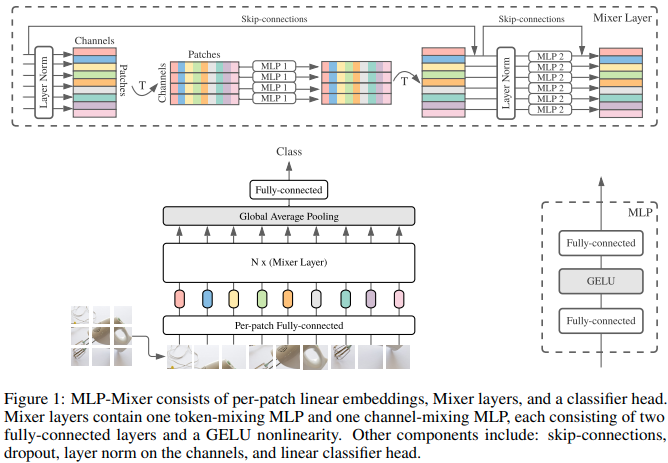

### Import libraries:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from types import SimpleNamespace
import os
import pickle

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load junction dataset

In [2]:
 # print(os.listdir(data_folder))

data_folder = 'foj_data/grayscale_junctions/'


# Start with purely junction images
# with open(data_folder + 'junction_data_24_10000_grey_multicolor_noiseless_centered.pkl','rb') as f:
# with open(data_folder + 'junction_data_24_20000_grey_multicolor_noiseless_centered.pkl','rb') as f:
with open(data_folder + 'junction_data_24_30000_grey_multicolor_noise_level_.2_center_range_1.pkl','rb') as f:
    data = pickle.load(f)

# wedges = data['wedges']
wedges_grey = data['wedges_grey']
params = data['params']
boundaries = data['boundaries']
wedges = data['wedges']

# Part 1: Using theta1, theta2, theta3, u, v representation

### Junction data represented as theta1, theta2, theta3, u, v.

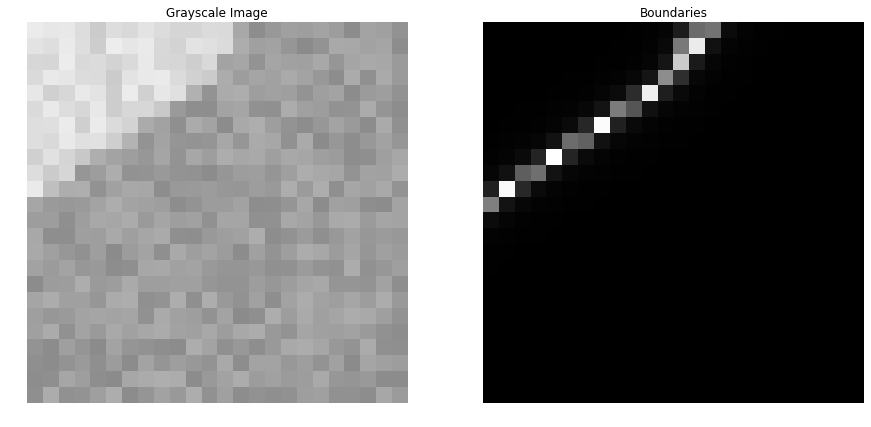

In [3]:
# Create data structure with optional transforms

# params: theta1, theta2, theta3, x0, y0
class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]

        if self.transform:
            image = self.transform(image)
            
        param = self.params[index,:]
        boundary = boundaries[index]

        return image, param, boundary

    def __len__(self):
        return len(self.images)

# # params: alpha, omega1, omega2, omega3, x0, y0

# class JunctionDataset(torch.utils.data.Dataset):
#     """ Dataset with support of transforms.
#     """

#     def __init__(self, images, params, boundaries, transform=None):
#         self.images = images
#         self.params = params
#         self.boundaries = boundaries
#         self.transform = transform

#     def __getitem__(self, index):
#         image = self.images[index]

#         if self.transform:
#             image = self.transform(image)
            
#         # Data generated as: theta1, theta2, theta3, u, v
#         # We want representation: alpha [orientation], omega1, omega2, omega3, u, v

#         jparam = self.params[index].squeeze()
#         center = jparam[3:]
#         angles_ord = torch.sort(jparam[:3])[0]
        
# #         print(angles_ord)

#         omega1 = angles_ord[1]-angles_ord[0]
#         omega2 = angles_ord[2]-angles_ord[1]
#         omega3 = 2*torch.pi - omega1 - omega2
        
#         angles = torch.tensor([angles_ord[0], omega1, omega2, omega3])
        
#         jparam_out = torch.cat((angles,center))

#         boundary = boundaries[index]

#         return image, jparam_out, boundary

#     def __len__(self):
#         return len(self.images)
    
    
# Make training and testing data
junc_data = JunctionDataset(wedges_grey, params, boundaries)#, transform=trainTransform)
data_size = len(junc_data)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junc_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


data = next(iter(test_loader))
wedge_image = data[0]
boundary_image = data[2]

# print(data[1][0])


img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(121)
plt.imshow(wedge_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(122)
plt.imshow(boundary_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

### Make transformation matrix L to go from local line parameters to global line parameters.

In [7]:
# Assume output of first network is 20 x 20
Wn,Hn = 20,20

# First define the center of the global coordinate system
xa,ya = torch.zeros((Wn,Hn),device=dev),torch.zeros((Wn,Hn),device=dev)

# First, let's make the transformation matrix:
y0, x0 = torch.meshgrid([torch.linspace(-1.0+4/24, 1.0-4/24, Wn, device=dev),
                               torch.linspace(-1.0+4/24, 1.0-4/24, Hn, device=dev)])

L = torch.zeros((1,3,3,Hn,Wn),device=dev)
L[:,0,0,:,:] = 1
L[:,1,1,:,:] = 1
L[:,2,2,:,:] = 1
L[:,0,2,:,:] = -x0+xa
L[:,1,2,:,:] = -y0+ya


Linv = torch.zeros_like(L)
for ii in range(L.shape[3]):
    for jj in range(L.shape[4]):
        Linv[0,:,:,ii,jj] = torch.inverse(L[0,:,:,ii,jj])

# L transforms line parameters for patches into the global coordinate system
# Linv transforms global line parameters into patch line parameters

/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Define simple line network

In [155]:
class offCenterLineNet(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.fc = nn.LazyLinear(3)
        self.activate = nn.ReLU()
#         self.avgpool = nn.AvgPool2d(2, stride=1)
#         self.batchnorm = nn.LazyBatchNorm1d()
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = x.view(x.shape[0],-1)
        
        x = self.fc(x)
         
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2],p=2,dim=1)).unsqueeze(1)       
        out = x/(norm_factor)#+eps)
#         print('Output shape=',x.shape)

#         out = x
        
        return out
    
H,W = 5,5
line_model = offCenterLineNet()
line_model = line_model.to(dev)
line_model.load_state_dict(torch.load('model_weights/line_network_noiseless_with_empty_patches.pt'));
summary(line_model, input_size=(1, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 4, 4]              80
              ReLU-2             [-1, 16, 4, 4]               0
            Conv2d-3             [-1, 16, 2, 2]           2,320
              ReLU-4             [-1, 16, 2, 2]               0
            Conv2d-5             [-1, 32, 1, 1]           2,080
              ReLU-6             [-1, 32, 1, 1]               0
            Linear-7                    [-1, 3]              99
Total params: 4,579
Trainable params: 4,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


### Convert line network to network that can handle images of arbitrary sizes

In [160]:
class offCenterLineNetBig(nn.Module):

    def __init__(self):
        super().__init__()
                
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2) #64 is good
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv4 = nn.Conv2d(32, 3, kernel_size=1)
        self.activate = nn.ReLU()
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activate(x)
        x = self.conv2(x)
        x = self.activate(x)
        x = self.conv3(x)
        x = self.activate(x)
        x = self.conv4(x)
        
        # We're defining
        # a = - sin(theta)
        # b = cos(theta)
        # c = -cy*cos(theta)+cx*sin(theta)
        # Hence, we want to normalize the vector by 1/sqrt(a^2 + b^2)
        norm_factor = (torch.norm(x[:,:2,:,:],p=2,dim=1)).unsqueeze(1)    
        out = x/(norm_factor)#+eps)
        
        return out
    

big_model = offCenterLineNetBig()
big_model = big_model.to(dev)
summary(big_model, input_size=(1, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 49, 49]              80
              ReLU-2           [-1, 16, 49, 49]               0
            Conv2d-3           [-1, 16, 47, 47]           2,320
              ReLU-4           [-1, 16, 47, 47]               0
            Conv2d-5           [-1, 32, 46, 46]           2,080
              ReLU-6           [-1, 32, 46, 46]               0
            Conv2d-7            [-1, 3, 46, 46]              99
Total params: 4,579
Trainable params: 4,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.21
Params size (MB): 0.02
Estimated Total Size (MB): 2.23
----------------------------------------------------------------


### Initialize weights for the big line network

In [161]:
# First load the line network:
big_model = offCenterLineNetBig();
big_model = big_model.to(dev)

offCenterLineNetWeights = line_model.state_dict();
offCenterLineNetWeightsBig = big_model.state_dict();

with torch.no_grad():
    big_model.conv1.weight.copy_(offCenterLineNetWeights['conv1.weight'])
    big_model.conv1.bias.copy_(offCenterLineNetWeights['conv1.bias'])
    big_model.conv2.weight.copy_(offCenterLineNetWeights['conv2.weight'])
    big_model.conv2.bias.copy_(offCenterLineNetWeights['conv2.bias'])
    big_model.conv3.weight.copy_(offCenterLineNetWeights['conv3.weight'])
    big_model.conv3.bias.copy_(offCenterLineNetWeights['conv3.bias'])
    big_model.conv4.weight.copy_(offCenterLineNetWeights['fc.weight'].view(offCenterLineNetWeightsBig['conv4.weight'].shape))
    big_model.conv4.bias.copy_(offCenterLineNetWeights['fc.bias'])
    
big_model.eval();


### Alternatively, you could give the MLPMixer ground truth line parameters

To do: Fix in the case of uniform patches

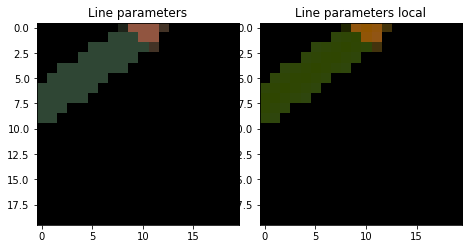

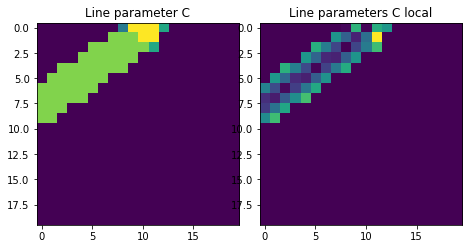

In [162]:
# Given a set of line parameters, construct the ground truth:

# Code if you are given theta1, theta2, theta3, u, v

def make_ground_truth(params,Linv,H,rf,x0,y0):
    
        theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        cx = params[:,3]
        cy = params[:,4]
        
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # radius threshold 
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        full_mask = mask1*mask2
        full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

        global_line_params = torch.stack((a,b,c),dim=4)
        
        ground_truth_global = torch.mean(global_line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        ground_truth_local = torch.einsum('ajbc,ajkbc->akbc',ground_truth_global.permute(0,3,1,2),Linv).permute(0,2,3,1)
        
        return ground_truth_global,ground_truth_local

# def make_ground_truth(params,Linv,H,rf,x0,y0):
    
# #         theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        
#         theta1 = params[:,0]
#         theta2 = params[:,0] + params[:,1]
#         theta3 = params[:,0] + params[:,1] + params[:,2]
        
#         theta = torch.stack((theta1,theta2,theta3),axis=1).unsqueeze(2).unsqueeze(3)
#         cx = params[:,4]
#         cy = params[:,5]
        
#         a = -torch.sin(theta)
#         b = torch.cos(theta)
#         c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

#         # radius threshold 
#         r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

#         mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
#         mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

#         full_mask = mask1*mask2
#         full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

#         global_line_params = torch.stack((a,b,c),dim=4)
        
#         ground_truth_global = torch.mean(global_line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
#         ground_truth_local = torch.einsum('ajbc,ajkbc->akbc',ground_truth_global.permute(0,3,1,2),Linv).permute(0,2,3,1)
        
#         return ground_truth_global,ground_truth_local
    

data = next(iter(test_loader))
gt_line_params = data[1].to(dev)

gt, gt_local = make_ground_truth(gt_line_params[0,:].squeeze().unsqueeze(0),Linv,24,10,x0,y0)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(torch.abs(gt[0].cpu()))
plt.title('Line parameters')
plt.subplot(222)
plt.imshow(torch.abs(gt_local[0].cpu()))
plt.title('Line parameters local')
plt.subplots_adjust(wspace=0, hspace=.15)

# For visualization purposes:
# Slopes (a/b) are the same, but c is different for local vs global
# SANITY CHECK: c is zero because all the lines go through the center

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(torch.abs(gt[0,:,:,2].cpu()))
plt.title('Line parameter C')
plt.subplot(222)
plt.imshow(torch.abs(gt_local[0,:,:,2].cpu()))
plt.title('Line parameters C local')
plt.subplots_adjust(wspace=0, hspace=.15)

### Define MLPMixer

In [7]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes)
    )

### The simplest MLPMixer learns from [24,24] junction images 

In [164]:
model = MLPMixer(
    image_size = 24,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 3,
    num_classes = 8
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, 24, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 144, 4]               0
            Linear-2             [-1, 144, 128]             640
         LayerNorm-3             [-1, 144, 128]             256
            Conv1d-4             [-1, 576, 128]          83,520
              GELU-5             [-1, 576, 128]               0
           Dropout-6             [-1, 576, 128]               0
            Conv1d-7             [-1, 144, 128]          83,088
           Dropout-8             [-1, 144, 128]               0
   PreNormResidual-9             [-1, 144, 128]               0
        LayerNorm-10             [-1, 144, 128]             256
           Linear-11              [-1, 144, 64]           8,256
             GELU-12              [-1, 144, 64]               0
          Dropout-13              [-1, 144, 64]               0
           Linear-14             [-1, 1

### Network output [cos(theta1), cos(theta2), cos(theta3), sin(theta1), sin(theta2), sin(theta3), u, v]

### No constraints on outputs of MLPMixer

In [165]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):
        
        angle_params = torch.cat((torch.cos(output_gt[:,:3]),torch.sin(output_gt[:,:3])),axis=1)
        
        loss = mse_loss(output_line_params[:,6:],output_gt[:,3:]) + mae_loss(output_line_params[:,:6],angle_params) 
        
        return loss

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

#     # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)

    new_inputs = inputs
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.6297667926433039, Avg. Test Loss: 0.5830110907554626
Epoch: 2, Avg. Train Loss: 0.5517307064112495, Avg. Test Loss: 0.5043408274650574
Epoch: 3, Avg. Train Loss: 0.4773562211616367, Avg. Test Loss: 0.4466902017593384
Epoch: 4, Avg. Train Loss: 0.4184067062303132, Avg. Test Loss: 0.3918865919113159
Epoch: 5, Avg. Train Loss: 0.3754731673820346, Avg. Test Loss: 0.36723509430885315
Epoch: 6, Avg. Train Loss: 0.35397369487612856, Avg. Test Loss: 0.3440127372741699
Epoch: 7, Avg. Train Loss: 0.33494435513720794, Avg. Test Loss: 0.32751479744911194
Epoch: 8, Avg. Train Loss: 0.3216851412081251, Avg. Test Loss: 0.32476550340652466
Epoch: 9, Avg. Train Loss: 0.3109046226623012, Avg. Test Loss: 0.3073200285434723
Epoch: 10, Avg. Train Loss: 0.30207668098748897, Avg. Test Loss: 0.30715423822402954
Epoch: 11, Avg. Train Loss: 0.2934787875297023, Avg. Test Loss: 0.29944220185279846
Epoch: 12, Avg. Train Loss: 0.2895587010710847, Avg. Test Loss: 0.2873477339744568
Epoch

KeyboardInterrupt: 

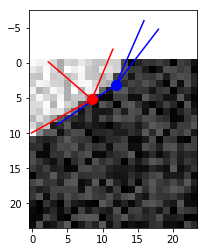

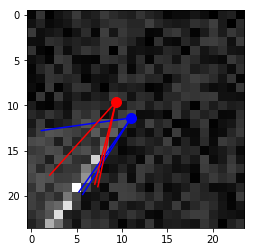

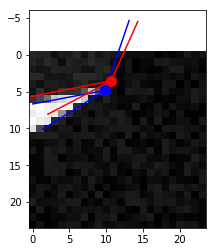

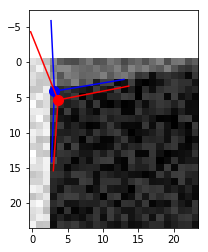

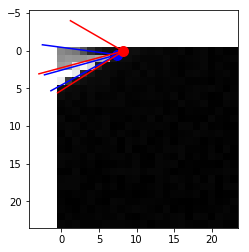

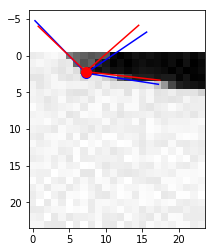

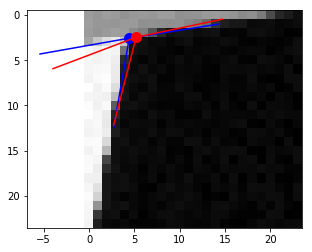

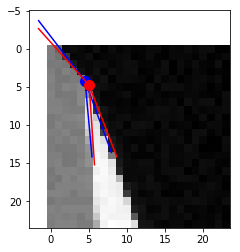

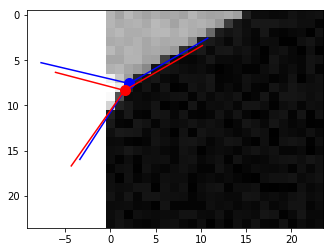

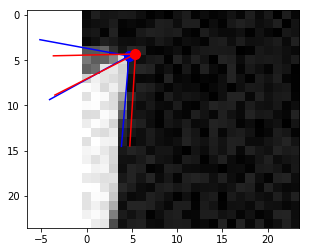

In [166]:
# What do the outputs look like? 

# model.eval();

# for batch_i, data in enumerate(test_loader):
#     # get the input images and their corresponding labels
#     inputs, output_gt, _ = data
    
#     inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
# #     gt_lines, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
# #     new_inputs = gt_lines.permute(0,3,1,2)

# #     line_params = big_model(inputs)  
# #     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)


#     new_inputs = inputs
    
#     # forward pass to get outputs
#     outputs = model(new_inputs).squeeze().detach().cpu()
    
#     gt = output_gt.cpu().squeeze()

# What do the outputs look like? 

model.eval();

# First load one batch of outputs
data = next(iter(test_loader))

inputs, output_gt, _ = data
inputs, output_gt = inputs.to(dev), output_gt.to(dev)

# forward pass to get outputs
outputs = model(inputs).squeeze().detach().cpu()

gt = output_gt.cpu().squeeze()
    
for ii in range(10):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

    center_gt = gt[ii][3:]*12 + 12

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:].detach().cpu()*12+12
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][2],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')



### Not perfect, but it's a start.

# How do the results compare if we normalize the outputs of the network?

I.e. if we enforce the outputs follow c^2 + s^2 = 1

In [22]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        
        # Output of neural network:
        # cos(theta1), cos(theta2), cos(theta3), sin(theta1), sin(theta2), sin(theta3), u, v
        
        # Required normalization:
        # Sin & cos theta terms so that cos(theta)**2 + sin(theta)**2 = 1    
        theta_norm = torch.sqrt(x[:,:3]**2 + x[:,3:6]**2)
    
        out1 = x[:,:3].clone()/theta_norm
        out2 = x[:,3:6].clone()/theta_norm
                
        return torch.cat((out1,out2,x[:,6:]),axis=1)
    
#         return x
    

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = 24,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 3,
    num_classes = 8
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, 24, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 144, 4]               0
            Linear-2             [-1, 144, 128]             640
         LayerNorm-3             [-1, 144, 128]             256
            Conv1d-4             [-1, 576, 128]          83,520
              GELU-5             [-1, 576, 128]               0
           Dropout-6             [-1, 576, 128]               0
            Conv1d-7             [-1, 144, 128]          83,088
           Dropout-8             [-1, 144, 128]               0
   PreNormResidual-9             [-1, 144, 128]               0
        LayerNorm-10             [-1, 144, 128]             256
           Linear-11              [-1, 144, 64]           8,256
             GELU-12              [-1, 144, 64]               0
          Dropout-13              [-1, 144, 64]               0
           Linear-14             [-1, 1

In [24]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):
        
        angle_params = torch.cat((torch.cos(output_gt[:,:3]),torch.sin(output_gt[:,:3])),axis=1)
#         angle_params = torch.cat((angle_params[:,::2],angle_params[:,1::2]),axis=1)
        
        loss = mse_loss(output_line_params[:,6:],output_gt[:,3:]) + mae_loss(output_line_params[:,:6],angle_params) 
        
        return loss

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

#     # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)

    new_inputs = inputs
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.6977565533974591, Avg. Test Loss: 0.6255141496658325
Epoch: 2, Avg. Train Loss: 0.5883335915266299, Avg. Test Loss: 0.5330753326416016
Epoch: 3, Avg. Train Loss: 0.506523994254131, Avg. Test Loss: 0.484436571598053
Epoch: 4, Avg. Train Loss: 0.46605808302467944, Avg. Test Loss: 0.43843579292297363
Epoch: 5, Avg. Train Loss: 0.42291177838456395, Avg. Test Loss: 0.40613988041877747
Epoch: 6, Avg. Train Loss: 0.3856835184144039, Avg. Test Loss: 0.37034809589385986
Epoch: 7, Avg. Train Loss: 0.3608655222490722, Avg. Test Loss: 0.3548480272293091
Epoch: 8, Avg. Train Loss: 0.3393474349788591, Avg. Test Loss: 0.34008893370628357
Epoch: 9, Avg. Train Loss: 0.3364860432989457, Avg. Test Loss: 0.33134856820106506
Epoch: 10, Avg. Train Loss: 0.3189341285649468, Avg. Test Loss: 0.3104570806026459
Epoch: 11, Avg. Train Loss: 0.30736566115828123, Avg. Test Loss: 0.30397239327430725
Epoch: 12, Avg. Train Loss: 0.30133143184231775, Avg. Test Loss: 0.30746448040008545
Epoc

KeyboardInterrupt: 

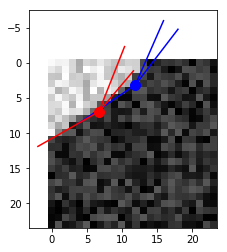

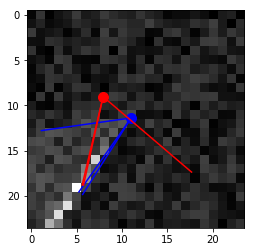

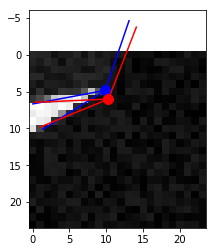

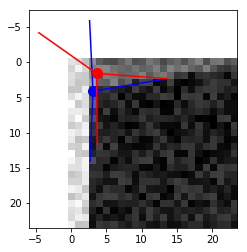

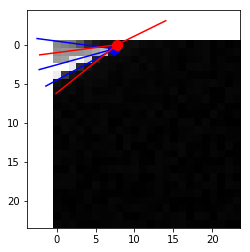

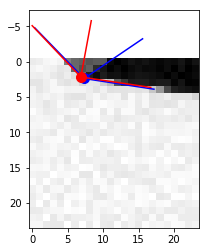

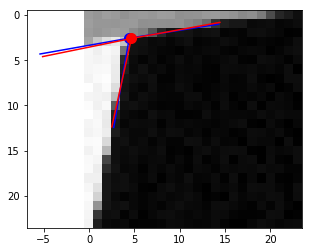

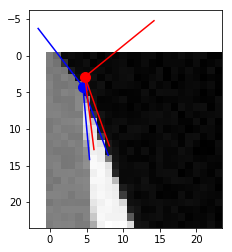

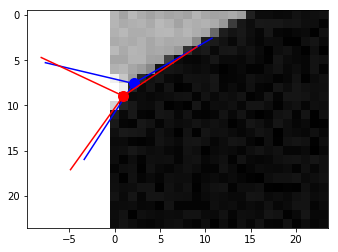

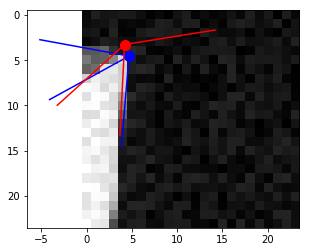

In [25]:
# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
inputs, output_gt = inputs.to(dev), output_gt.to(dev)

# forward pass to get outputs
outputs = model(inputs).squeeze().detach().cpu()

gt = output_gt.cpu().squeeze()

    
for ii in range(10):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

    center_gt = gt[ii][3:]*12 + 12

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,6:]*12+12
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([outputs[ii][3],outputs[ii][5]]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')



### Normalization doesn't seem to help performance

## What if we also constrain the output of the network with sigmoid functions?

In [9]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        
        # Output of neural network:
        # cos(theta1), cos(theta2), cos(theta3), sin(theta1), sin(theta2), sin(theta3), u, v
        
        # First map the sin/cosine outputs to be between -1 and 1
        x[:,:6] = self.tanh(x[:,:6])
        
        
        # Then normalize sin & cos theta terms so that cos(theta)**2 + sin(theta)**2 = 1    
        theta_norm = torch.sqrt(x[:,:3]**2 + x[:,3:6]**2)
    
        out1 = x[:,:3].clone()/theta_norm
        out2 = x[:,3:6].clone()/theta_norm
                
        return torch.cat((out1,out2,x[:,6:]),axis=1)
    
def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = 24,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 3,
    num_classes = 8
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, 24, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 144, 4]               0
            Linear-2             [-1, 144, 128]             640
         LayerNorm-3             [-1, 144, 128]             256
            Conv1d-4             [-1, 576, 128]          83,520
              GELU-5             [-1, 576, 128]               0
           Dropout-6             [-1, 576, 128]               0
            Conv1d-7             [-1, 144, 128]          83,088
           Dropout-8             [-1, 144, 128]               0
   PreNormResidual-9             [-1, 144, 128]               0
        LayerNorm-10             [-1, 144, 128]             256
           Linear-11              [-1, 144, 64]           8,256
             GELU-12              [-1, 144, 64]               0
          Dropout-13              [-1, 144, 64]               0
           Linear-14             [-1, 1

In [78]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):
        
        angle_params = torch.cat((torch.cos(output_gt[:,:3]),torch.sin(output_gt[:,:3])),axis=1)
#         angle_params = torch.cat((angle_params[:,::2],angle_params[:,1::2]),axis=1)
        
        loss = mse_loss(output_line_params[:,6:],output_gt[:,3:]) + mae_loss(output_line_params[:,:6],angle_params) 
        
        return loss

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

#     # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)

    new_inputs = inputs
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 0.7158820278504315, Avg. Test Loss: 0.6351843476295471
Epoch: 2, Avg. Train Loss: 0.6251870697619868, Avg. Test Loss: 0.6188675761222839
Epoch: 3, Avg. Train Loss: 0.6047895679286882, Avg. Test Loss: 0.5768730640411377
Epoch: 4, Avg. Train Loss: 0.5266517266338947, Avg. Test Loss: 0.5024355053901672
Epoch: 5, Avg. Train Loss: 0.4731897542289659, Avg. Test Loss: 0.44874054193496704
Epoch: 6, Avg. Train Loss: 0.42908523421661526, Avg. Test Loss: 0.4142426550388336
Epoch: 7, Avg. Train Loss: 0.40297091240976374, Avg. Test Loss: 0.3916163444519043
Epoch: 8, Avg. Train Loss: 0.38189898226775376, Avg. Test Loss: 0.37052008509635925
Epoch: 9, Avg. Train Loss: 0.3894147428811765, Avg. Test Loss: 0.3796490728855133
Epoch: 10, Avg. Train Loss: 0.35914795305214675, Avg. Test Loss: 0.3538787066936493
Epoch: 11, Avg. Train Loss: 0.3595557113488515, Avg. Test Loss: 0.3472869098186493
Epoch: 12, Avg. Train Loss: 0.3400721661016053, Avg. Test Loss: 0.34319594502449036
Epoch:

Epoch: 99, Avg. Train Loss: 0.13529794984588436, Avg. Test Loss: 0.16900786757469177
Epoch: 100, Avg. Train Loss: 0.13843418774651547, Avg. Test Loss: 0.16456402838230133
Epoch: 101, Avg. Train Loss: 0.13385285729286717, Avg. Test Loss: 0.16283923387527466
Epoch: 102, Avg. Train Loss: 0.13296478563079647, Avg. Test Loss: 0.16272306442260742
Epoch: 103, Avg. Train Loss: 0.13339166343212128, Avg. Test Loss: 0.16599132120609283
Epoch: 104, Avg. Train Loss: 0.13356011959851957, Avg. Test Loss: 0.16259217262268066
Epoch: 105, Avg. Train Loss: 0.13132206146039216, Avg. Test Loss: 0.16506381332874298
Epoch: 106, Avg. Train Loss: 0.132599682784548, Avg. Test Loss: 0.16510996222496033
Epoch: 107, Avg. Train Loss: 0.13863551908848332, Avg. Test Loss: 0.16300415992736816
Epoch: 108, Avg. Train Loss: 0.13080044193010704, Avg. Test Loss: 0.16331550478935242
Epoch: 109, Avg. Train Loss: 0.13031508510603623, Avg. Test Loss: 0.16252310574054718
Epoch: 110, Avg. Train Loss: 0.129489939586789, Avg. Test

KeyboardInterrupt: 

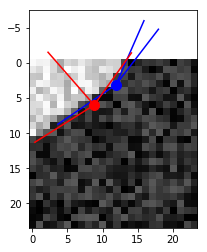

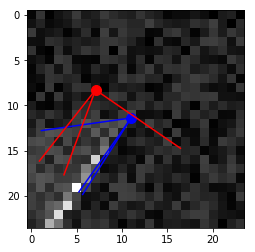

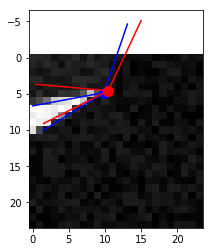

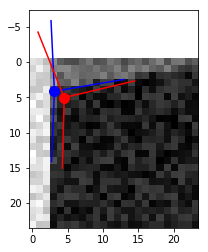

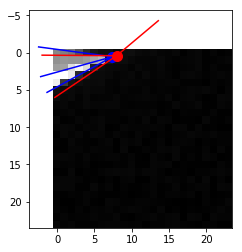

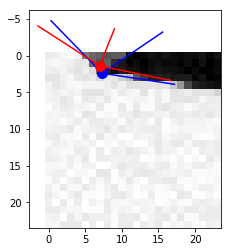

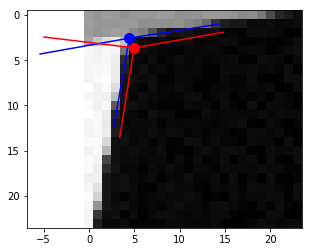

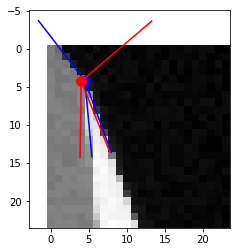

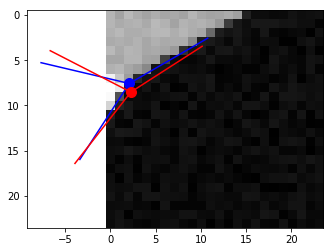

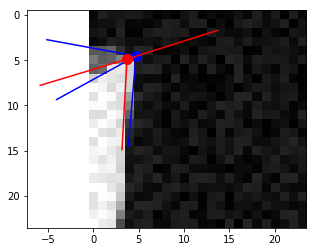

In [79]:
# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
inputs, output_gt = inputs.to(dev), output_gt.to(dev)

# forward pass to get outputs
outputs = model(inputs).squeeze().detach().cpu()

gt = output_gt.cpu().squeeze()


def plot_results(inputs, outputs, gt):
    for ii in range(10):

        plt.figure()
        plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

        center_gt = gt[ii][3:]*12 + 12

        plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)

        line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
        line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)

        line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
        line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)

        line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
        line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)

        plt.plot(line1[0,:],line1[1,:],'-b')
        plt.plot(line2[0,:],line2[1,:],'-b')
        plt.plot(line3[0,:],line3[1,:],'-b')


        center_output = outputs[ii,6:]*12+12

        plt.plot(center_output[0],center_output[1],'ro',markersize=10)

        line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
        line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)

        line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
        line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)

        line3_end = (center_output + 10*np.array([outputs[ii][3],outputs[ii][5]]))
        line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)

        plt.plot(line1[0,:],line1[1,:],'-r')
        plt.plot(line2[0,:],line2[1,:],'-r')
        plt.plot(line3[0,:],line3[1,:],'-r')

plot_results(inputs, outputs, gt)

In [ ]:
# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
inputs, output_gt = inputs.to(dev), output_gt.to(dev)

# forward pass to get outputs
outputs = model(inputs).squeeze().detach().cpu()

gt = output_gt.cpu().squeeze()


def plot_results(inputs, outputs, gt):
    for ii in range(10):

        plt.figure()
        plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

        center_gt = gt[ii][3:]*12 + 12

        plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)

        line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
        line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)

        line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
        line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)

        line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
        line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)

        plt.plot(line1[0,:],line1[1,:],'-b')
        plt.plot(line2[0,:],line2[1,:],'-b')
        plt.plot(line3[0,:],line3[1,:],'-b')


        center_output = outputs[ii,6:]*12+12

        plt.plot(center_output[0],center_output[1],'ro',markersize=10)

        line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
        line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)

        line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
        line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)

        line3_end = (center_output + 10*np.array([outputs[ii][3],outputs[ii][5]]))
        line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)

        plt.plot(line1[0,:],line1[1,:],'-r')
        plt.plot(line2[0,:],line2[1,:],'-r')
        plt.plot(line3[0,:],line3[1,:],'-r')

plot_results(inputs, outputs, gt)

## What if we accept any permuation of the output? (i.e. we accept the lowest loss permutation for each output)

### There are 3 ways to order the 3 (sorted) output angles 

In [4]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        
        # Output of neural network:
        # cos(theta1), cos(theta2), cos(theta3), sin(theta1), sin(theta2), sin(theta3), u, v
        
        # First map the sin/cosine outputs to be between -1 and 1
        x[:,:6] = self.tanh(x[:,:6])
        
        # Then normalize sin & cos theta terms so that cos(theta)**2 + sin(theta)**2 = 1    
        theta_norm = torch.sqrt(x[:,:3]**2 + x[:,3:6]**2)
    
        out1 = x[:,:3].clone()/theta_norm
        out2 = x[:,3:6].clone()/theta_norm
                
        return torch.cat((out1,out2,x[:,6:]),axis=1)
    
def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = 24,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 3,
    num_classes = 8
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, 24, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 144, 4]               0
            Linear-2             [-1, 144, 128]             640
         LayerNorm-3             [-1, 144, 128]             256
            Conv1d-4             [-1, 576, 128]          83,520
              GELU-5             [-1, 576, 128]               0
           Dropout-6             [-1, 576, 128]               0
            Conv1d-7             [-1, 144, 128]          83,088
           Dropout-8             [-1, 144, 128]               0
   PreNormResidual-9             [-1, 144, 128]               0
        LayerNorm-10             [-1, 144, 128]             256
           Linear-11              [-1, 144, 64]           8,256
             GELU-12              [-1, 144, 64]               0
          Dropout-13              [-1, 144, 64]               0
           Linear-14             [-1, 1

In [5]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss(reduce=False)
mae_loss = nn.L1Loss(reduce=False)

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):

        output_angles = torch.atan2(output_line_params[:,3:6],output_line_params[:,:3])
        output_angles = (output_angles + 2*torch.pi) % (2*torch.pi)

        # First, order the output angles
        output_angle_ord1 = torch.argsort(output_angles,axis=1)
        output_angle_ord2 = torch.stack((output_angle_ord1[:,1],output_angle_ord1[:,2],output_angle_ord1[:,0]),axis=1)
        output_angle_ord3 = torch.stack((output_angle_ord1[:,2],output_angle_ord1[:,0],output_angle_ord1[:,1]),axis=1)

        output_angle_ord1 = torch.cat((output_angle_ord1,output_angle_ord1+3),axis=1)
        output_angle_ord2 = torch.cat((output_angle_ord2,output_angle_ord2+3),axis=1)
        output_angle_ord3 = torch.cat((output_angle_ord3,output_angle_ord3+3),axis=1)
        
        gt = torch.cat((torch.cos(output_gt[:,:3]),torch.sin(output_gt[:,:3])),axis=1)
        
        vertex_loss = mse_loss(output_line_params[:,6:],output_gt[:,3:]).mean(1)
        
        loss_perm1 =  mae_loss(output_line_params[torch.arange(output_line_params.shape[0]).repeat(6,1).T,output_angle_ord1],gt).mean(1) 
        loss_perm2 =  mae_loss(output_line_params[torch.arange(output_line_params.shape[0]).repeat(6,1).T,output_angle_ord2],gt).mean(1) 
        loss_perm3 =  mae_loss(output_line_params[torch.arange(output_line_params.shape[0]).repeat(6,1).T,output_angle_ord3],gt).mean(1) 
    
        return torch.mean(torch.min(torch.stack((loss_perm1,loss_perm2,loss_perm3),axis=1),axis=1)[0] + vertex_loss)

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

#     # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)

    new_inputs = inputs
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

/n/home03/mpolansky/.conda/envs/torch_cuda9/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, Avg. Train Loss: 0.5995708762430677, Avg. Test Loss: 0.5550905466079712
Epoch: 2, Avg. Train Loss: 0.5451270715863097, Avg. Test Loss: 0.5427320599555969
Epoch: 3, Avg. Train Loss: 0.5260027693767174, Avg. Test Loss: 0.5117682218551636
Epoch: 4, Avg. Train Loss: 0.49142134481785343, Avg. Test Loss: 0.4749860167503357
Epoch: 5, Avg. Train Loss: 0.4659520954478021, Avg. Test Loss: 0.44792065024375916
Epoch: 6, Avg. Train Loss: 0.42150712539167967, Avg. Test Loss: 0.4089469015598297
Epoch: 7, Avg. Train Loss: 0.38611116596296724, Avg. Test Loss: 0.3721849024295807
Epoch: 8, Avg. Train Loss: 0.36015646948533897, Avg. Test Loss: 0.35056883096694946
Epoch: 9, Avg. Train Loss: 0.34609036001504634, Avg. Test Loss: 0.3431496024131775
Epoch: 10, Avg. Train Loss: 0.33263106907115264, Avg. Test Loss: 0.3248947560787201
Epoch: 11, Avg. Train Loss: 0.3373367675379211, Avg. Test Loss: 0.32754847407341003
Epoch: 12, Avg. Train Loss: 0.3170057266366248, Avg. Test Loss: 0.3189704716205597
Epoc

Epoch: 99, Avg. Train Loss: 0.13314894630628474, Avg. Test Loss: 0.1629246324300766
Epoch: 100, Avg. Train Loss: 0.1330770610594282, Avg. Test Loss: 0.16351646184921265
Epoch: 101, Avg. Train Loss: 0.13278827757812015, Avg. Test Loss: 0.16163954138755798
Epoch: 102, Avg. Train Loss: 0.13447393272437302, Avg. Test Loss: 0.16334910690784454
Epoch: 103, Avg. Train Loss: 0.13113132250659607, Avg. Test Loss: 0.16227899491786957
Epoch: 104, Avg. Train Loss: 0.13113069797263427, Avg. Test Loss: 0.16275770962238312
Epoch: 105, Avg. Train Loss: 0.1320096207600014, Avg. Test Loss: 0.1633663922548294
Epoch: 106, Avg. Train Loss: 0.13046903075540767, Avg. Test Loss: 0.16177619993686676
Epoch: 107, Avg. Train Loss: 0.1300930857074027, Avg. Test Loss: 0.16139790415763855
Epoch: 108, Avg. Train Loss: 0.12928511801303602, Avg. Test Loss: 0.16008712351322174
Epoch: 109, Avg. Train Loss: 0.12863370381733952, Avg. Test Loss: 0.16067729890346527
Epoch: 110, Avg. Train Loss: 0.12920953976173027, Avg. Test 

KeyboardInterrupt: 

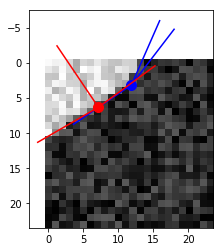

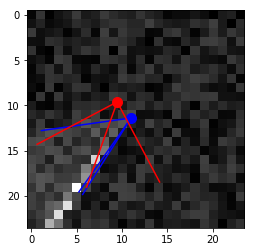

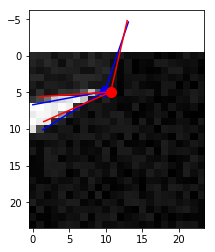

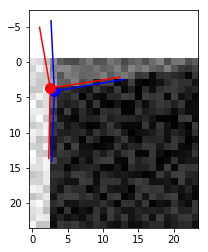

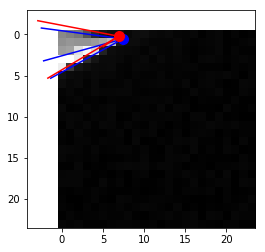

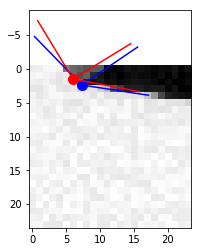

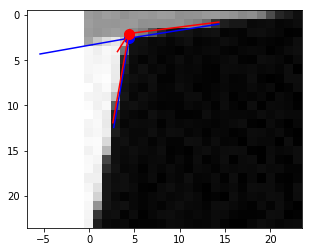

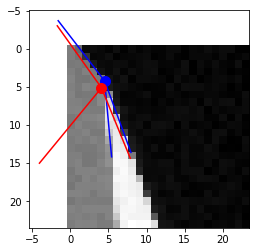

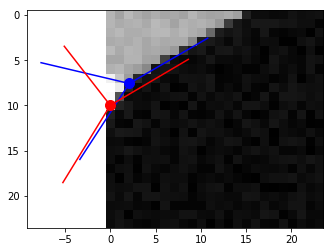

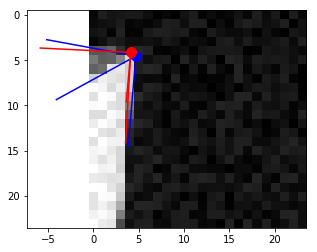

In [6]:
# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
inputs, output_gt = inputs.to(dev), output_gt.to(dev)

# forward pass to get outputs
outputs = model(inputs).squeeze().detach().cpu()

gt = output_gt.cpu().squeeze()


def plot_results(inputs, outputs, gt):
    for ii in range(10):

        plt.figure()
        plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

        center_gt = gt[ii][3:]*12 + 12

        plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)

        line1_end = (center_gt + 10*np.array([np.cos(gt[ii][0]),np.sin(gt[ii][0])]))
        line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)

        line2_end = (center_gt + 10*np.array([np.cos(gt[ii][1]),np.sin(gt[ii][1])]))
        line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)

        line3_end = (center_gt + 10*np.array([np.cos(gt[ii][2]),np.sin(gt[ii][2])]))
        line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)

        plt.plot(line1[0,:],line1[1,:],'-b')
        plt.plot(line2[0,:],line2[1,:],'-b')
        plt.plot(line3[0,:],line3[1,:],'-b')


        center_output = outputs[ii,6:]*12+12

        plt.plot(center_output[0],center_output[1],'ro',markersize=10)

        line1_end = (center_output + 10*np.array([outputs[ii][0],outputs[ii][3]]))
        line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)

        line2_end = (center_output + 10*np.array([outputs[ii][1],outputs[ii][4]]))
        line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)

        line3_end = (center_output + 10*np.array([outputs[ii][3],outputs[ii][5]]))
        line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)

        plt.plot(line1[0,:],line1[1,:],'-r')
        plt.plot(line2[0,:],line2[1,:],'-r')
        plt.plot(line3[0,:],line3[1,:],'-r')

plot_results(inputs, outputs, gt)

### More parameters?

In [26]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        
        # Output of neural network:
        # cos(theta1), cos(theta2), cos(theta3), sin(theta1), sin(theta2), sin(theta3), u, v
        
        # First map the sin/cosine outputs to be between -1 and 1
        x[:,:6] = self.tanh(x[:,:6])
        
        
        # Then normalize sin & cos theta terms so that cos(theta)**2 + sin(theta)**2 = 1    
        theta_norm = torch.sqrt(x[:,:3]**2 + x[:,3:6]**2)
    
        out1 = x[:,:3].clone()/theta_norm
        out2 = x[:,3:6].clone()/theta_norm
                
        return torch.cat((out1,out2,x[:,6:]),axis=1)
    
def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = 24,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 6,
    num_classes = 8
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, 24, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 144, 4]               0
            Linear-2             [-1, 144, 128]             640
         LayerNorm-3             [-1, 144, 128]             256
            Conv1d-4             [-1, 576, 128]          83,520
              GELU-5             [-1, 576, 128]               0
           Dropout-6             [-1, 576, 128]               0
            Conv1d-7             [-1, 144, 128]          83,088
           Dropout-8             [-1, 144, 128]               0
   PreNormResidual-9             [-1, 144, 128]               0
        LayerNorm-10             [-1, 144, 128]             256
           Linear-11              [-1, 144, 64]           8,256
             GELU-12              [-1, 144, 64]               0
          Dropout-13              [-1, 144, 64]               0
           Linear-14             [-1, 1

### Allow for any permutation of the outputs

Epoch: 1, Avg. Train Loss: 0.5858806196381064, Avg. Test Loss: 0.5492167472839355
Epoch: 2, Avg. Train Loss: 0.5423323488702961, Avg. Test Loss: 0.5460784435272217
Epoch: 3, Avg. Train Loss: 0.5318092657070533, Avg. Test Loss: 0.5120669603347778
Epoch: 4, Avg. Train Loss: 0.48144252978119195, Avg. Test Loss: 0.45081764459609985
Epoch: 5, Avg. Train Loss: 0.4262160635461994, Avg. Test Loss: 0.41302689909935
Epoch: 6, Avg. Train Loss: 0.4035123744431664, Avg. Test Loss: 0.4054529368877411
Epoch: 7, Avg. Train Loss: 0.39045537628379523, Avg. Test Loss: 0.37862566113471985
Epoch: 8, Avg. Train Loss: 0.36647646742708545, Avg. Test Loss: 0.3617328703403473
Epoch: 9, Avg. Train Loss: 0.35707629545062197, Avg. Test Loss: 0.361964613199234
Epoch: 10, Avg. Train Loss: 0.34178531228327286, Avg. Test Loss: 0.3429374396800995
Epoch: 11, Avg. Train Loss: 0.33011257882211725, Avg. Test Loss: 0.33159056305885315
Epoch: 12, Avg. Train Loss: 0.32727809805496066, Avg. Test Loss: 0.3323720395565033
Epoch:

Epoch: 99, Avg. Train Loss: 0.1253661884396684, Avg. Test Loss: 0.15429896116256714
Epoch: 100, Avg. Train Loss: 0.12314909550489164, Avg. Test Loss: 0.1535327136516571
Epoch: 101, Avg. Train Loss: 0.12278694995478087, Avg. Test Loss: 0.15363235771656036
Epoch: 102, Avg. Train Loss: 0.12285311841497235, Avg. Test Loss: 0.15773345530033112
Epoch: 103, Avg. Train Loss: 0.12553491633312375, Avg. Test Loss: 0.15363724529743195
Epoch: 104, Avg. Train Loss: 0.12220676447830948, Avg. Test Loss: 0.1536073088645935
Epoch: 105, Avg. Train Loss: 0.1218583442124666, Avg. Test Loss: 0.1541651040315628
Epoch: 106, Avg. Train Loss: 0.12095980390029795, Avg. Test Loss: 0.15351031720638275
Epoch: 107, Avg. Train Loss: 0.11978116616898891, Avg. Test Loss: 0.1527550369501114
Epoch: 108, Avg. Train Loss: 0.12137540853491016, Avg. Test Loss: 0.153647318482399
Epoch: 109, Avg. Train Loss: 0.11921305925238367, Avg. Test Loss: 0.15374672412872314
Epoch: 110, Avg. Train Loss: 0.12027359403231565, Avg. Test Los

Epoch: 210, Avg. Train Loss: 0.0807567601110421, Avg. Test Loss: 0.14870990812778473
Epoch: 211, Avg. Train Loss: 0.08253907368463628, Avg. Test Loss: 0.14915865659713745
Epoch: 212, Avg. Train Loss: 0.08074111915102192, Avg. Test Loss: 0.1493721306324005
Epoch: 213, Avg. Train Loss: 0.0810509160453198, Avg. Test Loss: 0.14760573208332062
Epoch: 214, Avg. Train Loss: 0.07893445021381565, Avg. Test Loss: 0.14923274517059326
Epoch: 215, Avg. Train Loss: 0.07927011829965255, Avg. Test Loss: 0.15073616802692413
Epoch: 216, Avg. Train Loss: 0.08042879417246464, Avg. Test Loss: 0.14997388422489166
Epoch: 217, Avg. Train Loss: 0.08057749943405974, Avg. Test Loss: 0.15091487765312195
Epoch: 218, Avg. Train Loss: 0.07969776847783257, Avg. Test Loss: 0.1502125859260559
Epoch: 219, Avg. Train Loss: 0.07939941260744543, Avg. Test Loss: 0.14878886938095093
Epoch: 220, Avg. Train Loss: 0.07768676941301308, Avg. Test Loss: 0.14888973534107208
Epoch: 221, Avg. Train Loss: 0.07757583406626009, Avg. Tes

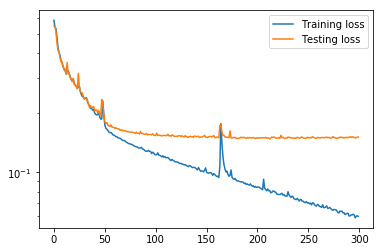

In [27]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.01) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss(reduce=False)
mae_loss = nn.L1Loss(reduce=False)

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):
        
#         angle_params = torch.cat((torch.cos(output_gt[:,:3]),torch.sin(output_gt[:,:3])),axis=1)

        permutes = torch.tensor([[0,1,2], [0,2,1], [1,2,0], [1,0,2], [2,0,1], [2,1,0]])
        
        angle_params_permute1 = torch.cat((torch.cos(output_gt[:,permutes[0]]),torch.sin(output_gt[:,permutes[0]])),axis=1)
        angle_params_permute2 = torch.cat((torch.cos(output_gt[:,permutes[1]]),torch.sin(output_gt[:,permutes[1]])),axis=1)
        angle_params_permute3 = torch.cat((torch.cos(output_gt[:,permutes[2]]),torch.sin(output_gt[:,permutes[2]])),axis=1)
        angle_params_permute4 = torch.cat((torch.cos(output_gt[:,permutes[3]]),torch.sin(output_gt[:,permutes[3]])),axis=1)
        angle_params_permute5 = torch.cat((torch.cos(output_gt[:,permutes[4]]),torch.sin(output_gt[:,permutes[4]])),axis=1)
        angle_params_permute6 = torch.cat((torch.cos(output_gt[:,permutes[5]]),torch.sin(output_gt[:,permutes[5]])),axis=1)
        
        
        loss_perm1 = mse_loss(output_line_params[:,6:],output_gt[:,3:]).mean(1) + mae_loss(output_line_params[:,:6],angle_params_permute1).mean(1) 
        loss_perm2 = mse_loss(output_line_params[:,6:],output_gt[:,3:]).mean(1) + mae_loss(output_line_params[:,:6],angle_params_permute2).mean(1) 
        loss_perm3 = mse_loss(output_line_params[:,6:],output_gt[:,3:]).mean(1) + mae_loss(output_line_params[:,:6],angle_params_permute3).mean(1) 
        loss_perm4 = mse_loss(output_line_params[:,6:],output_gt[:,3:]).mean(1) + mae_loss(output_line_params[:,:6],angle_params_permute4).mean(1) 
        loss_perm5 = mse_loss(output_line_params[:,6:],output_gt[:,3:]).mean(1) + mae_loss(output_line_params[:,:6],angle_params_permute5).mean(1) 
        loss_perm6 = mse_loss(output_line_params[:,6:],output_gt[:,3:]).mean(1) + mae_loss(output_line_params[:,:6],angle_params_permute6).mean(1) 
        
        return torch.mean(torch.min(torch.stack((loss_perm1,loss_perm2,loss_perm3,loss_perm4,loss_perm5,loss_perm6),axis=1),axis=1)[0])

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()

#     # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)

    new_inputs = inputs
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

# Part 2: Let's train a network using the M-junction convention

torch.Size([500, 6])


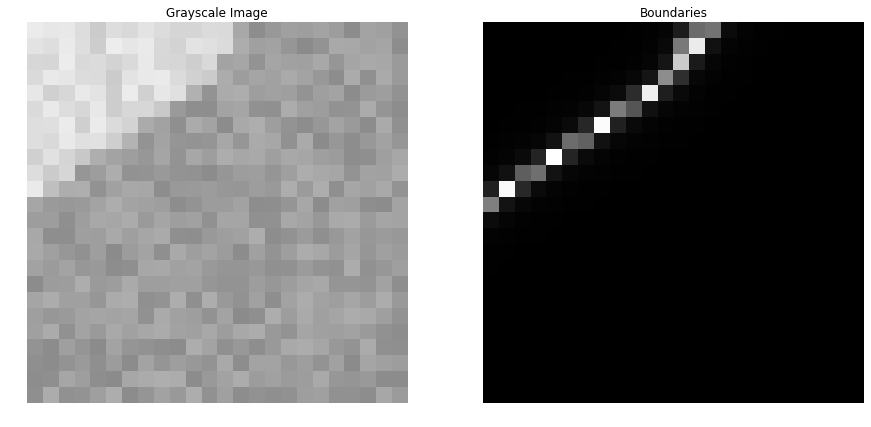

In [4]:
class JunctionDataset(torch.utils.data.Dataset):
    """ Dataset with support of transforms.
    """

    def __init__(self, images, params, boundaries, transform=None):
        self.images = images
        self.params = params
        self.boundaries = boundaries
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]

        if self.transform:
            image = self.transform(image)
            
        # Data generated as: theta1, theta2, theta3, u, v
        # We want representation: alpha [orientation], omega1, omega2, omega3, u, v

        jparam = self.params[index].squeeze()
        center = jparam[3:]
        angles_ord = torch.sort(jparam[:3])[0]
        
        omega1 = angles_ord[1]-angles_ord[0]
        omega2 = angles_ord[2]-angles_ord[1]
        omega3 = 2*torch.pi - omega1 - omega2
        
        angles = torch.tensor([angles_ord[0], omega1, omega2, omega3])
        
        jparam_out = torch.cat((angles,center))

        boundary = boundaries[index]

        return image, jparam_out, boundary

    def __len__(self):
        return len(self.images)
    
    
# Make training and testing data
junc_data = JunctionDataset(wedges_grey, params, boundaries)#, transform=trainTransform)
data_size = len(junc_data)

train_proportion = .85
# Split dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(junc_data, [int(data_size*train_proportion), int(data_size*(1-train_proportion))], generator=torch.Generator().manual_seed(42))

# Create loaders for the training and testing data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False) #len(test_dataset)


data = next(iter(test_loader))
wedge_image = data[0]
boundary_image = data[2]

# print(data[1][0])

print(data[1].shape)

img_show = 0
plt.figure(figsize=[15, 15])
plt.subplot(121)
plt.imshow(wedge_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale Image')
plt.axis('off');
plt.subplot(122)
plt.imshow(boundary_image[0].squeeze().cpu(),cmap='gray', vmin=0, vmax=1)
plt.title('Boundaries')
plt.axis('off');

In [5]:
def make_ground_truth(params,Linv,H,rf,x0,y0):
    
#         theta = params[:,:3].unsqueeze(2).unsqueeze(3)
        
        theta1 = params[:,0]
        theta2 = params[:,0] + params[:,1]
        theta3 = params[:,0] + params[:,1] + params[:,2]
        
        theta = torch.stack((theta1,theta2,theta3),axis=1).unsqueeze(2).unsqueeze(3)
        cx = params[:,4]
        cy = params[:,5]
        
        a = -torch.sin(theta)
        b = torch.cos(theta)
        c = torch.sin(theta)*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - torch.cos(theta)*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # radius threshold 
        r = rf/2*.8/H # divide the receptive field by 2, multiply by a factor .8 (because we want enough of the line to be included), and then scale by the size of the original (not cropped) image

        mask1 = (torch.abs(a*x0.unsqueeze(0).unsqueeze(1) + b*y0.unsqueeze(0).unsqueeze(1) + c)<r)
        mask2 = (b*x0.unsqueeze(0).unsqueeze(1) - a*y0.unsqueeze(0).unsqueeze(1) > b*cx.unsqueeze(1).unsqueeze(2).unsqueeze(3) - a*cy.unsqueeze(1).unsqueeze(2).unsqueeze(3) )

        full_mask = mask1*mask2
        full_mask = full_mask/torch.max(full_mask.view(params.shape[0],-1,3),1)[0].unsqueeze(2).unsqueeze(3)

        global_line_params = torch.stack((a,b,c),dim=4)
        
        ground_truth_global = torch.mean(global_line_params*(full_mask.unsqueeze(4)),1)#(line_params*(full_mask.unsqueeze(4))).sum(1)
        ground_truth_local = torch.einsum('ajbc,ajkbc->akbc',ground_truth_global.permute(0,3,1,2),Linv).permute(0,2,3,1)
        
        return ground_truth_global,ground_truth_local
    

In [6]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        
        # Output of neural network:
        # cos(alpha), sin(alpha), omega1, omega2, omega3, u, v
        
        # Required normalization:
        # First two terms so that cos(alpha)**2 + sin(alpha)**2 = 1
        # Third to fifth term so that omega1 + omega2 + omega3 = 2*pi
        
#         out1 = x[:,:2]/(torch.norm(x[:,:2],p=2,dim=1,keepdim=True)**2)
#         out2 = x[:,2:5]/(2*torch.pi)
#         out3 = x[:,5:]
        
#         return torch.cat((out1,out2,out3),axis=1)

        return x
    

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = 24,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 3,
    num_classes = 7
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, 24, 24))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 144, 4]               0
            Linear-2             [-1, 144, 128]             640
         LayerNorm-3             [-1, 144, 128]             256
            Conv1d-4             [-1, 576, 128]          83,520
              GELU-5             [-1, 576, 128]               0
           Dropout-6             [-1, 576, 128]               0
            Conv1d-7             [-1, 144, 128]          83,088
           Dropout-8             [-1, 144, 128]               0
   PreNormResidual-9             [-1, 144, 128]               0
        LayerNorm-10             [-1, 144, 128]             256
           Linear-11              [-1, 144, 64]           8,256
             GELU-12              [-1, 144, 64]               0
          Dropout-13              [-1, 144, 64]               0
           Linear-14             [-1, 1

In [32]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):
        # output_gt = alpha, theta1, theta2, theta3, u, v
        # output_line_params = cos(alpha), sin(alpha), omega1, omega2, omega3, u, v

        alpha_gt = torch.stack((torch.cos(output_gt[:,0]),torch.sin(output_gt[:,0])),axis=1)
        
        loss = mse_loss(output_line_params[:,5:],output_gt[:,4:]) \
                + mae_loss(output_line_params[:,:2],alpha_gt) \
                + mae_loss(output_line_params[:,2:5],output_gt[:,2:5])  
        
        return loss

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()
    
    # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)

    new_inputs = inputs 
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 1.344517791972441, Avg. Test Loss: 1.0400234460830688
Epoch: 2, Avg. Train Loss: 0.9547387770577973, Avg. Test Loss: 0.8457836508750916
Epoch: 3, Avg. Train Loss: 0.7844737674675736, Avg. Test Loss: 0.6996808648109436
Epoch: 4, Avg. Train Loss: 0.682302223701103, Avg. Test Loss: 0.6520917415618896
Epoch: 5, Avg. Train Loss: 0.6387287892547309, Avg. Test Loss: 0.6347811818122864
Epoch: 6, Avg. Train Loss: 0.6128968935386807, Avg. Test Loss: 0.5893192887306213
Epoch: 7, Avg. Train Loss: 0.5833622708040125, Avg. Test Loss: 0.5886009931564331
Epoch: 8, Avg. Train Loss: 0.5633428050022499, Avg. Test Loss: 0.5554834604263306
Epoch: 9, Avg. Train Loss: 0.5420801756428737, Avg. Test Loss: 0.5320895910263062
Epoch: 10, Avg. Train Loss: 0.5244965009829577, Avg. Test Loss: 0.5376173853874207
Epoch: 11, Avg. Train Loss: 0.5236402598081851, Avg. Test Loss: 0.5327996015548706
Epoch: 12, Avg. Train Loss: 0.5066293378671011, Avg. Test Loss: 0.5151799321174622
Epoch: 13, Avg.

KeyboardInterrupt: 

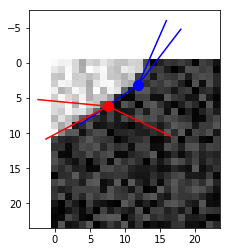

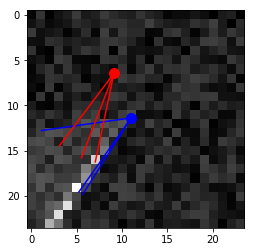

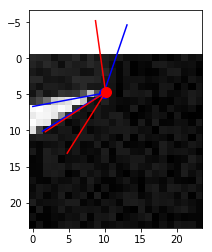

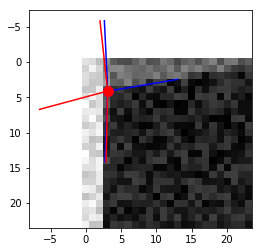

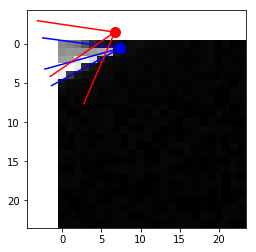

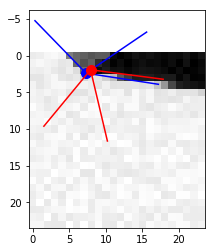

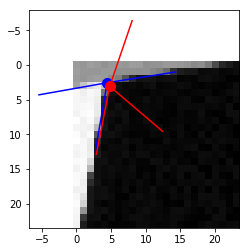

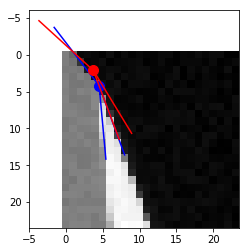

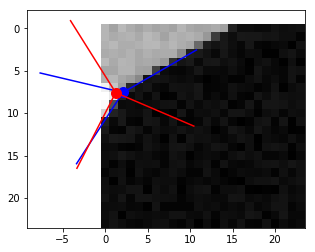

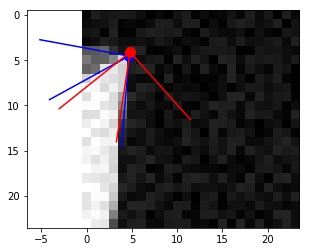

In [33]:
# Visualize the outputs

# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

_, output_gt, _ = data
output_gt = output_gt.to(dev)

# forward pass to get outputs
outputs,_ = forward_pass(data, opts, 0)

outputs = outputs.cpu().detach()

gt = output_gt.cpu().squeeze()

# Plot 10 examples of the outputs    
for ii in range(10):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

    center_gt = gt[ii][4:]*12 + 12

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    gt_angles = torch.stack((gt[:,0],gt[:,0]+gt[:,1],gt[:,0]+gt[:,1]+gt[:,2]),axis=1)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt_angles[ii][0]),np.sin(gt_angles[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt_angles[ii][1]),np.sin(gt_angles[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt_angles[ii][2]),np.sin(gt_angles[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,5:]*12+12
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    alpha = torch.atan2(outputs[:,1],outputs[:,0])
    
    output_angles = torch.stack((alpha, alpha + outputs[:,2],alpha + outputs[:,2] + outputs[:,3]),axis=1)
    
    line1_end = (center_output + 10*np.array([np.cos(output_angles[ii][0]),np.sin(output_angles[ii][0])]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([np.cos(output_angles[ii][1]),np.sin(output_angles[ii][1])]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([np.cos(output_angles[ii][2]),np.sin(output_angles[ii][2])]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')



### What if we normalize the outputs?

In [7]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


# class NormalizeOutputs(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x):
        
#         # Output of neural network:
#         # cos(alpha), sin(alpha), omega1, omega2, omega3, u, v
        
#         # Required normalization:
#         # First two terms so that cos(alpha)**2 + sin(alpha)**2 = 1
#         # Third to fifth term so that omega1 + omega2 + omega3 = 2*pi
        
#         out1 = x[:,:2].clone()/(torch.norm(x[:,:2],p=2,dim=1,keepdim=True))
#         out2 = torch.abs(x[:,2:5])/(2*torch.pi)
#         out3 = x[:,5:]
             
#         return torch.cat((out1,out2,out3),axis=1)


class NormalizeOutputs(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # Output of neural network:
        # cos(theta1), cos(theta2), cos(theta3), sin(theta1), sin(theta2), sin(theta3), u, v
        
        # First map the orientation sin/cosine to be between -1 and 1
        x[:,:2] = self.tanh(x[:,:2])
        
        # Then normalize  so that cos(theta)**2 + sin(theta)**2 = 1    
        out1 = x[:,:2]/(torch.sqrt(x[:,0]**2 + x[:,1]**2)).unsqueeze(1)
        
        # Next, map the three angles to be between 0 and 1, and then scale to sum to 2*pi
        xs = self.sigmoid(x[:,2:5])
        
        out2 = xs/torch.sum(xs,1).unsqueeze(1) * 2*torch.pi
       
        return torch.cat((out1,out2,x[:,5:]),axis=1)
    

def MLPMixer(*, image_size, channels, patch_size, dim, depth, num_classes, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
    image_h, image_w = pair(image_size)
    assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
    num_patches = (image_h // patch_size) * (image_w // patch_size)
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        Reduce('b n c -> b c', 'mean'),
        nn.Linear(dim, num_classes),
        NormalizeOutputs()
    )

model = MLPMixer(
    image_size = 24,
    channels = 1,
    patch_size = 2,
    dim = 128,
    depth = 3,
    num_classes = 7
)

# img = torch.randn(1, 3, 256, 256)
# pred = model(img) # (1, 1000)
model = model.to(dev)

summary(model, input_size=(1, 24, 24))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1               [-1, 144, 4]               0
            Linear-2             [-1, 144, 128]             640
         LayerNorm-3             [-1, 144, 128]             256
            Conv1d-4             [-1, 576, 128]          83,520
              GELU-5             [-1, 576, 128]               0
           Dropout-6             [-1, 576, 128]               0
            Conv1d-7             [-1, 144, 128]          83,088
           Dropout-8             [-1, 144, 128]               0
   PreNormResidual-9             [-1, 144, 128]               0
        LayerNorm-10             [-1, 144, 128]             256
           Linear-11              [-1, 144, 64]           8,256
             GELU-12              [-1, 144, 64]               0
          Dropout-13              [-1, 144, 64]               0
           Linear-14             [-1, 1

In [18]:
# Now let's train the initial network 

model.train();

optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

n_epochs = 300

mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
ce_loss = nn.CrossEntropyLoss()
bce_loss = nn.BCEWithLogitsLoss() #nn.functional.binary_cross_entropy_with_logits()
mlsm_loss = nn.MultiLabelSoftMarginLoss()

opts = SimpleNamespace()
opts.patchmin                 = -1.0    # Lower bound (xmin = ymin) of (square) patch domain
opts.patchmax                 =  1.0    # Upper bound (xmax = ymax) of (square) patch domain
opts.patchres                 =  50    # Number of pixels in each dimension of square patch
opts.delta                    =  .1   # Dirac delta relaxation parameter for rendering boundary maps

 
def get_loss(output_line_params, output_gt):
        # output_gt = alpha, theta1, theta2, theta3, u, v
        # output_line_params = cos(alpha), sin(alpha), omega1, omega2, omega3, u, v

        alpha_gt = torch.stack((torch.cos(output_gt[:,0]),torch.sin(output_gt[:,0])),axis=1)
        
        loss = mse_loss(output_line_params[:,5:],output_gt[:,4:]) \
                + mae_loss(output_line_params[:,:2],alpha_gt) \
                + mae_loss(output_line_params[:,2:5],output_gt[:,1:4])  
        
        return loss

def forward_pass(data, opts, training):
    
    # Load inputs from data
    inputs, output_gt, _ = data
    inputs, output_gt = inputs.to(dev), output_gt.to(dev)
    
    # zero the parameter (weight) gradients
    optimizer.zero_grad()
    
    # Interpret inputs as their ground truth
#     gt, _ = make_ground_truth(output_gt.squeeze(),Linv,24,10,x0,y0)
#     new_inputs = gt.permute(0,3,1,2)
#     line_params = big_model(inputs)  
#     new_inputs = torch.einsum('ajbc,ajkbc->akbc',line_params,L)

    new_inputs = inputs 
    
    # forward pass to get outputs
    output_line_params = model(new_inputs)
    
    loss = get_loss(output_line_params,output_gt.squeeze())
#     loss, angles_gt_oh = (output_line_params,output_gt, opts)
    
    if training:

        # backward pass to calculate the parameter gradients
        loss.backward()

        # update the parameters
        optimizer.step()
        
    return output_line_params, loss#, angles_gt_oh
    
for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    
    if epoch == 0:
        train_loss_over_time = [] # to track the loss as the network trains
        test_loss_over_time = []
        
    if epoch == 50:
        optimizer = torch.optim.Adam(model.parameters(),lr=.001) 
        
    running_loss = 0
    num_batches = 0
    
    model.train();
    for batch_i, data in enumerate(train_loader):
        
        # get the input images and their corresponding labels
        num_batches += 1

        _,loss = forward_pass(data, opts, training = 1)

        # to convert loss into a scalar and add it to running_loss, we use .item()
        running_loss += loss.item()
    
    # Calculate test data loss after each epoch
    with torch.no_grad():
        test_loss = 0
        num_batches_test = 0
        for batch_i, data in enumerate(test_loader):
            num_batches_test += 1    

            _,loss = forward_pass(data, opts, training = 0)

            test_loss += loss
                    
        test_loss_over_time.append(test_loss/num_batches_test)

    # Calculate model loss:
    avg_loss = running_loss/num_batches
    train_loss_over_time.append(avg_loss)

    print('Epoch: {}, Avg. Train Loss: {}, Avg. Test Loss: {}'.format(epoch + 1, train_loss_over_time[-1], test_loss_over_time[-1]))
    
print('Finished Training')

plt.figure()
plt.semilogy(np.arange(0,n_epochs),train_loss_over_time[0:])
plt.semilogy(np.arange(0,n_epochs),test_loss_over_time[0:])
plt.legend(['Training loss', 'Testing loss'])

Epoch: 1, Avg. Train Loss: 1.288268501852073, Avg. Test Loss: 0.7538235783576965
Epoch: 2, Avg. Train Loss: 0.6954794058612749, Avg. Test Loss: 0.659909188747406
Epoch: 3, Avg. Train Loss: 0.6274872971516029, Avg. Test Loss: 0.6223388910293579
Epoch: 4, Avg. Train Loss: 0.5899436146605248, Avg. Test Loss: 0.6009019017219543
Epoch: 5, Avg. Train Loss: 0.5764572725576513, Avg. Test Loss: 0.6088942289352417
Epoch: 6, Avg. Train Loss: 0.5562583196396921, Avg. Test Loss: 0.5950415730476379
Epoch: 7, Avg. Train Loss: 0.5408571502741646, Avg. Test Loss: 0.5708321928977966
Epoch: 8, Avg. Train Loss: 0.5203940307392794, Avg. Test Loss: 0.5635870099067688
Epoch: 9, Avg. Train Loss: 0.508010061932545, Avg. Test Loss: 0.5760499835014343
Epoch: 10, Avg. Train Loss: 0.5055304859198776, Avg. Test Loss: 0.5588718056678772
Epoch: 11, Avg. Train Loss: 0.4961483145461363, Avg. Test Loss: 0.5566585063934326
Epoch: 12, Avg. Train Loss: 0.49247557100127726, Avg. Test Loss: 0.5652549862861633
Epoch: 13, Avg.

KeyboardInterrupt: 

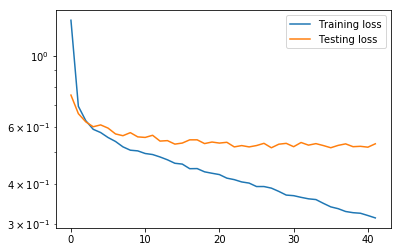

In [20]:
plt.figure()
plt.semilogy(np.arange(len(train_loss_over_time)),train_loss_over_time)
plt.semilogy(np.arange(len(test_loss_over_time)),test_loss_over_time)
plt.legend(['Training loss', 'Testing loss'])

### I should probably add more data/reduce network complexity to prevent memorization of the inputs

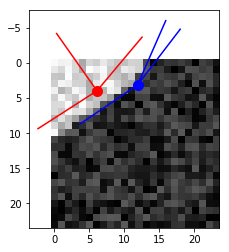

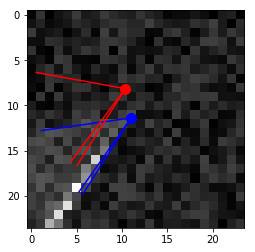

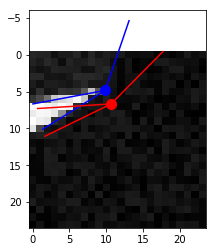

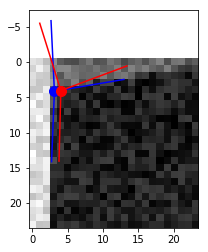

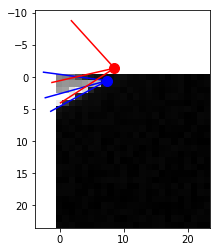

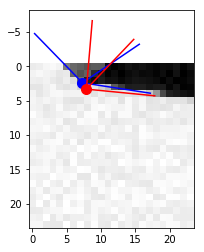

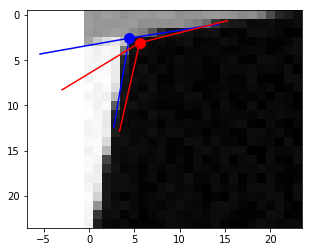

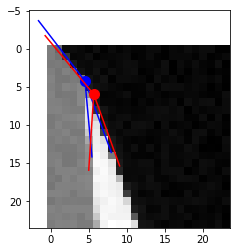

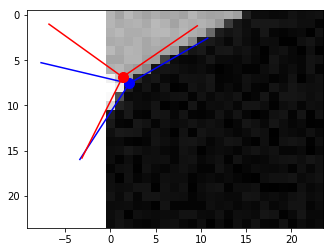

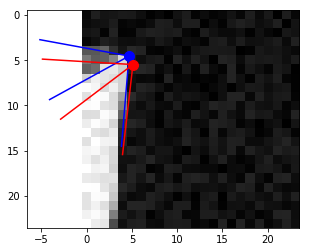

In [19]:
# Visualize the outputs

# First load one batch of outputs

model.eval();

data = next(iter(test_loader))

inputs, output_gt, _ = data
output_gt = output_gt.to(dev)

# forward pass to get outputs
outputs,_ = forward_pass(data, opts, 0)

outputs = outputs.cpu().detach()

gt = output_gt.cpu().squeeze()

# Plot 10 examples of the outputs    
for ii in range(10):
    
    plt.figure()
    plt.imshow(inputs[ii].cpu().squeeze(),cmap='gray')

    center_gt = gt[ii][4:]*12 + 12

    plt.plot(center_gt[0],center_gt[1],'bo',markersize=10)
    
    gt_angles = torch.stack((gt[:,0],gt[:,0]+gt[:,1],gt[:,0]+gt[:,1]+gt[:,2]),axis=1)
    
    line1_end = (center_gt + 10*np.array([np.cos(gt_angles[ii][0]),np.sin(gt_angles[ii][0])]))
    line1 = np.concatenate((center_gt[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_gt + 10*np.array([np.cos(gt_angles[ii][1]),np.sin(gt_angles[ii][1])]))
    line2 = np.concatenate((center_gt[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_gt + 10*np.array([np.cos(gt_angles[ii][2]),np.sin(gt_angles[ii][2])]))
    line3 = np.concatenate((center_gt[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    plt.plot(line1[0,:],line1[1,:],'-b')
    plt.plot(line2[0,:],line2[1,:],'-b')
    plt.plot(line3[0,:],line3[1,:],'-b')
    
    
    center_output = outputs[ii,5:]*12+12
    
    plt.plot(center_output[0],center_output[1],'ro',markersize=10)

    alpha = torch.atan2(outputs[:,1],outputs[:,0])
    
    output_angles = torch.stack((alpha, alpha + outputs[:,2],alpha + outputs[:,2] + outputs[:,3]),axis=1)
    
    line1_end = (center_output + 10*np.array([np.cos(output_angles[ii][0]),np.sin(output_angles[ii][0])]))
    line1 = np.concatenate((center_output[:,np.newaxis],line1_end[:,np.newaxis]),axis=1)
    
    line2_end = (center_output + 10*np.array([np.cos(output_angles[ii][1]),np.sin(output_angles[ii][1])]))
    line2 = np.concatenate((center_output[:,np.newaxis],line2_end[:,np.newaxis]),axis=1)
    
    line3_end = (center_output + 10*np.array([np.cos(output_angles[ii][2]),np.sin(output_angles[ii][2])]))
    line3 = np.concatenate((center_output[:,np.newaxis],line3_end[:,np.newaxis]),axis=1)
    
    
    plt.plot(line1[0,:],line1[1,:],'-r')
    plt.plot(line2[0,:],line2[1,:],'-r')
    plt.plot(line3[0,:],line3[1,:],'-r')

